In [55]:
!pip install datasets pandas matplotlib seqeval -q


In [56]:
import os 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import json 
from datasets import load_dataset
import seqeval
from seqeval.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score      
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import pandas as pd
from datasets import load_dataset
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')


In [57]:
save_root = 'local/img/'


# Parsing des fichiers

Dans le serveur, localiser le fichier à copier (en général, dans les checkpoints) qui s'appelle `trainer_state.json`. Le copier avec `scp`. Voici un exemple de syntaxe. 

```{bash}
rsync -av --exclude '*.safetensors' --exclude '*.bin' --exclude '*.pt' --exclude '*.pth' au78760@ens.ad.etsmtl.ca@logti-hyper-c1.ens.ad.etsmtl.ca:~/mti881-projet2/checkpoints/ ./local/
scp au78760@ens.ad.etsmtl.ca@logti-hyper-c1.ens.ad.etsmtl.ca:~/mti881-projet2/checkpoints/model.safetensors ./local/
```

In [58]:
trainer_state_file = 'local1/trainer_state.json'

# Load the trainer state
try :
    with open(trainer_state_file, 'r') as f:
        log = json.load(f)
except json.JSONDecodeError as e:
    print(f"Error decoding JSON: {e}")
    log = None
except FileNotFoundError as e:
    print(f"File not found: {e}")
    log = None
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    log = None

# Analyse

## Métriques globales

In [59]:
def extract_global_metrics(log):
    """
    Extracts global metrics from the trainer state log.
    """
    global_metrics_val = []
    global_metric_train = []
    keys_val = [
        'eval_loss', 'eval_overall_accuracy', 'eval_overall_f1', 
        'eval_overall_precision', 'eval_overall_recall', 'step'
    ] 
    keys_train = [
        "epoch", "grad_norm", "learning_rate", "loss", "step"
    ]
    for entry in log['log_history']:
        # Validation metrics
        keys, values = entry.keys(), entry.values()
        if all(key in keys for key in keys_val):
            metrics = {key: value for key, value in zip(keys, values) if key in keys_val}
            global_metrics_val.append(metrics)

        # Training metrics
        if all(key in keys for key in keys_train):
            metrics = {key: value for key, value in zip(keys, values) if key in keys_train}
            global_metric_train.append(metrics)
    
    # Convert to DataFrame for easier manipulation
    df_train = pd.DataFrame(global_metric_train)
    df_val = pd.DataFrame(global_metrics_val)
    # Concatenate the DataFrames
    df = df_train.join(df_val, rsuffix='_val')
    # Choose epoch and step as first columns

    cols = df.columns.tolist()
    cols = ["epoch", "step", "step_val"] + [col for col in cols if col not in ["epoch", "step", "step_val"]]
    df = df[cols]
    return df


df_global = extract_global_metrics(log)
df_global.head()

,epoch,step,step_val,grad_norm,learning_rate,loss,eval_loss,eval_overall_accuracy,eval_overall_f1,eval_overall_precision,eval_overall_recall
0,0.687285,500,500,1.689597,0.000009,0.9164,0.617679,0.823528,0.430392,0.445638,0.416155
1,1.373883,1000,1000,2.096715,0.000009,0.5946,0.535067,0.839851,0.485781,0.493922,0.477904
2,2.060481,1500,1500,2.349780,0.000008,0.5293,0.502425,0.848854,0.522726,0.545506,0.501773
3,2.747766,2000,2000,1.780960,0.000007,0.4849,0.480432,0.852749,0.536257,0.538502,0.534031
4,3.434364,2500,2500,1.558536,0.000007,0.4566,0.472066,0.855029,0.549208,0.540783,0.557900


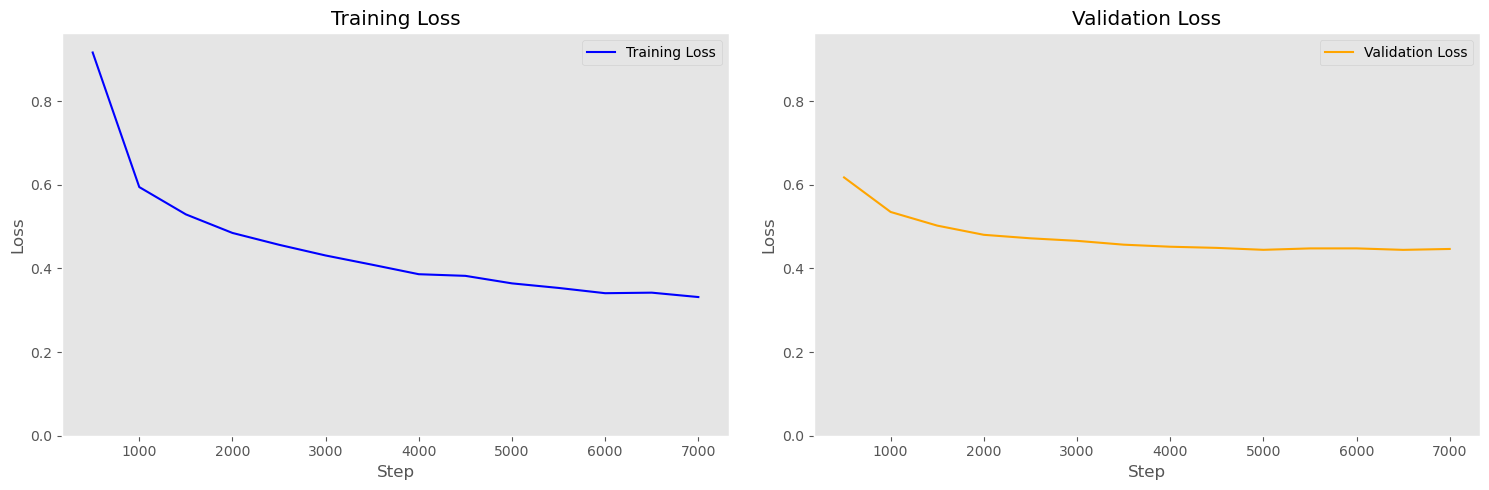

In [60]:

def plot_loss(df_global):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    max_loss = max(df_global['loss'].max(), df_global['eval_loss'].max()) * 1.05


    # Training loss
    ax[0].plot(df_global['step'], df_global['loss'], label='Training Loss', color='blue')
    ax[0].set_title('Training Loss')
    ax[0].set_xlabel('Step')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    ax[0].grid()
    # Validation loss
    ax[1].plot(df_global["step_val"], df_global['eval_loss'], label='Validation Loss', color='orange')
    ax[1].set_title('Validation Loss')
    ax[1].set_xlabel('Step')
    ax[1].set_ylabel('Loss')
    ax[1].legend()
    ax[1].grid()
    plt.tight_layout()
    ax[0].set_ylim(0, max_loss)
    ax[1].set_ylim(0, max_loss)
    plt.show()
    return fig, ax

fig, ax = plot_loss(df_global)
fig.savefig(f'{save_root}/loss.png', dpi=300, bbox_inches='tight')


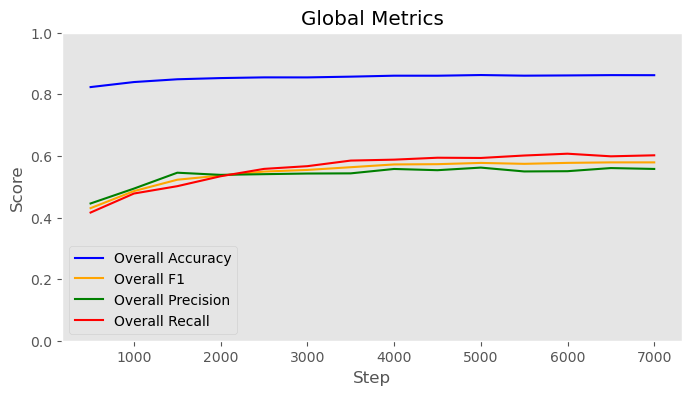

(<Figure size 800x400 with 1 Axes>,
 <AxesSubplot:title={'center':'Global Metrics'}, xlabel='Step', ylabel='Score'>)

In [ ]:
def plot_global_metrics(df_global):
    fig, ax = plt.subplots(figsize=(8, 4))
    metric_name = ['eval_overall_accuracy', 'eval_overall_f1', 'eval_overall_precision', 'eval_overall_recall']
    metric_label = ['Overall Accuracy', 'Overall F1', 'Overall Precision', 'Overall Recall']
    colors = ['blue', 'orange', 'green', 'red']
    for i, metric in enumerate(metric_name):
        ax.plot(df_global["step_val"], df_global[metric], label=metric_label[i], color=colors[i])
    ax.set_title('Global Metrics')
    ax.set_xlabel('Step')
    ax.set_ylabel('Score')
    plt.ylim(0, 1)
    ax.legend()
    ax.grid()
    plt.show()
    return fig, ax

    # Overall accuracy
fig, ax = plot_global_metrics(df_global)
fig.savefig(f'{save_root}/global_metrics.png', dpi=300, bbox_inches='tight')

# Analyse des métriques par classe 